In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import torch
from torchvision import datasets, transforms
import tarfile
import os
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [58]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load SVHN dataset
svhn = list(torch.utils.data.DataLoader(
    datasets.SVHN('data', split="test", download=True,
                   transform=transform_test),
    batch_size=1, shuffle=True))

Using downloaded and verified file: data\test_32x32.mat


In [59]:
lsun_tar_path = 'LSUN.tar.gz'
lsun_extract_folder = 'LSUN/'

# Extract the LSUN dataset
with tarfile.open(lsun_tar_path, "r:gz") as tar:
    tar.extractall(path=lsun_extract_folder)


In [60]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the LSUN dataset
lsun_dataset = datasets.ImageFolder(root=lsun_extract_folder, transform=transform_test)
lsun_loader = torch.utils.data.DataLoader(lsun_dataset, batch_size=1, shuffle=True)


In [61]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim*2)  # Outputs mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        flat_x = x.view(x.size(0), -1)
        params = self.encoder(flat_x)
        mu, log_var = params[:, :latent_dim], params[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    x_flat = x.view(x.size(0), -1)
    recon_loss = nn.functional.mse_loss(recon_x, x_flat, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

def train_vae(model, data_loader, optimizer, epochs=50, device=torch.device('cpu')):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in data_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstruction, mu, log_var = model(data)
            loss = vae_loss(reconstruction, data, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}')

# Parameters and setup
input_dim = 3 * 32 * 32
latent_dim = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR datasets
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar100_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)

cifar10_loader = DataLoader(cifar10_dataset, batch_size=128, shuffle=True)
cifar100_loader = DataLoader(cifar100_dataset, batch_size=128, shuffle=True)

# Initialize models and optimizers
model_cifar10 = VAE(input_dim, latent_dim).to(device)
model_cifar100 = VAE(input_dim, latent_dim).to(device)

optimizer_cifar10 = torch.optim.Adam(model_cifar10.parameters(), lr=learning_rate)
optimizer_cifar100 = torch.optim.Adam(model_cifar100.parameters(), lr=learning_rate)

# Train models
print("Training on CIFAR-10:")
train_vae(model_cifar10, cifar10_loader, optimizer_cifar10, epochs=50, device=device)

print("Training on CIFAR-100:")
train_vae(model_cifar100, cifar100_loader, optimizer_cifar100, epochs=50, device=device)

# Define the path to the LSUN tar.gz file and the directory to extract to
lsun_tar_path = 'LSUN.tar.gz'
lsun_extract_folder = 'LSUN/'

# Extract the LSUN dataset
with tarfile.open(lsun_tar_path, "r:gz") as tar:
    tar.extractall(path=lsun_extract_folder)

# Load LSUN dataset
lsun_dataset = datasets.ImageFolder(root=lsun_extract_folder, transform=transform)
lsun_loader = DataLoader(lsun_dataset, batch_size=128, shuffle=True)

# Load SVHN dataset
svhn_dataset = datasets.SVHN(root='./data', split='train', transform=transforms.ToTensor(), download=True)
svhn_loader = DataLoader(svhn_dataset, batch_size=128, shuffle=True)

# Test the models on LSUN and SVHN
print("Testing CIFAR-10 model on LSUN:")
train_vae(model_cifar10, lsun_loader, optimizer_cifar10, epochs=50, device=device)

print("Testing CIFAR-10 model on SVHN:")
train_vae(model_cifar10, svhn_loader, optimizer_cifar10, epochs=50, device=device)

print("Testing CIFAR-100 model on LSUN:")
train_vae(model_cifar100, lsun_loader, optimizer_cifar100, epochs=50, device=device)

print("Testing CIFAR-100 model on SVHN:")
train_vae(model_cifar100, svhn_loader, optimizer_cifar100, epochs=50, device=device)


Files already downloaded and verified
Files already downloaded and verified
Training on CIFAR-10:
Epoch 1, Loss: 16098.108518322411
Epoch 2, Loss: 12297.507491558104
Epoch 3, Loss: 11413.317390305307
Epoch 4, Loss: 11099.415984404972
Epoch 5, Loss: 10892.931670596228
Epoch 6, Loss: 10720.956714054508
Epoch 7, Loss: 10611.835219439337
Epoch 8, Loss: 10500.9758019801
Epoch 9, Loss: 10400.055117087595
Epoch 10, Loss: 10319.760783397938
Epoch 11, Loss: 10251.60754051111
Epoch 12, Loss: 10205.63689108456
Epoch 13, Loss: 10172.212096387468
Epoch 14, Loss: 10140.36915061541
Epoch 15, Loss: 10115.453010110294
Epoch 16, Loss: 10084.756526234814
Epoch 17, Loss: 10051.023085338076
Epoch 18, Loss: 10035.481702565537
Epoch 19, Loss: 10028.997017862852
Epoch 20, Loss: 9997.837372372522
Epoch 21, Loss: 9983.383754096069
Epoch 22, Loss: 9967.405997742168
Epoch 23, Loss: 9946.789871723146
Epoch 24, Loss: 9940.168665581043
Epoch 25, Loss: 9926.304551380674
Epoch 26, Loss: 9897.019229040121
Epoch 27, Los

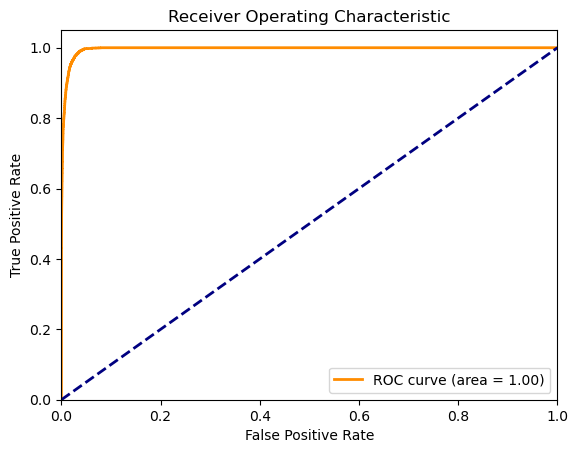

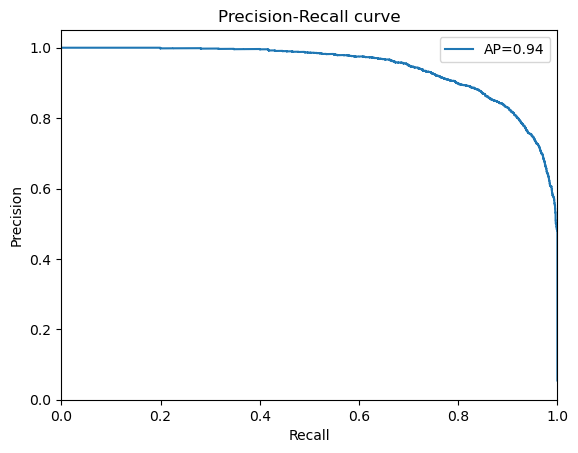

In [67]:
class Metrics:
    def __init__(self, model, data_loader, device):
        self.model = model.to(device)
        self.data_loader = data_loader
        self.device = device

    def evaluate(self):
        self.model.eval()
        recon_errors, true_labels = [], []
        with torch.no_grad():
            for data, _ in self.data_loader:
                data = data.to(self.device)
                reconstruction, _, _ = self.model(data)
                reconstruction = reconstruction.view(data.size(0), -1)
                data = data.view(data.size(0), -1)
                mse = ((reconstruction - data) ** 2).mean(dim=1).cpu().numpy()
                recon_errors.extend(mse)

                threshold = np.percentile(mse, 95) 
                labels = (mse > threshold).astype(int)
                true_labels.extend(labels)

        return np.array(true_labels), np.array(recon_errors)

    def plot_roc_curve(self):
        labels, scores = self.evaluate()
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self):
        labels, scores = self.evaluate()
        precision, recall, thresholds = precision_recall_curve(labels, scores)
        ap = average_precision_score(labels, scores)

        plt.figure()
        plt.step(recall, precision, where='post', label=f'AP={ap:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve')
        plt.legend(loc="upper right")
        plt.show()

# Assuming you have already defined your VAE model, data loader, and device
metrics = Metrics(model_cifar10, cifar10_loader, device) 
metrics.plot_roc_curve()
metrics.plot_precision_recall_curve()


Airplane: AUROC: 0.59, AUPR: 0.12, FPR at TPR 95%: 0.9159111111111111, with Threshold: 0.20680662989616394
Automobile: AUROC: 0.52, AUPR: 0.12, FPR at TPR 95%: 0.9384222222222223, with Threshold: 0.18270954489707947
Bird: AUROC: 0.47, AUPR: 0.09, FPR at TPR 95%: 0.9524666666666667, with Threshold: 0.16370084881782532
Cat: AUROC: 0.44, AUPR: 0.09, FPR at TPR 95%: 0.9711333333333333, with Threshold: 0.1371002346277237
Deer: AUROC: 0.40, AUPR: 0.08, FPR at TPR 95%: 0.9530444444444445, with Threshold: 0.16560105979442596
Dog: AUROC: 0.39, AUPR: 0.07, FPR at TPR 95%: 0.9680888888888889, with Threshold: 0.14555351436138153
Frog: AUROC: 0.41, AUPR: 0.08, FPR at TPR 95%: 0.9622888888888889, with Threshold: 0.15707308053970337
Horse: AUROC: 0.52, AUPR: 0.10, FPR at TPR 95%: 0.9400888888888889, with Threshold: 0.1891924887895584
Ship: AUROC: 0.59, AUPR: 0.13, FPR at TPR 95%: 0.9291111111111111, with Threshold: 0.20493410527706146
Truck: AUROC: 0.69, AUPR: 0.21, FPR at TPR 95%: 0.8330888888888889

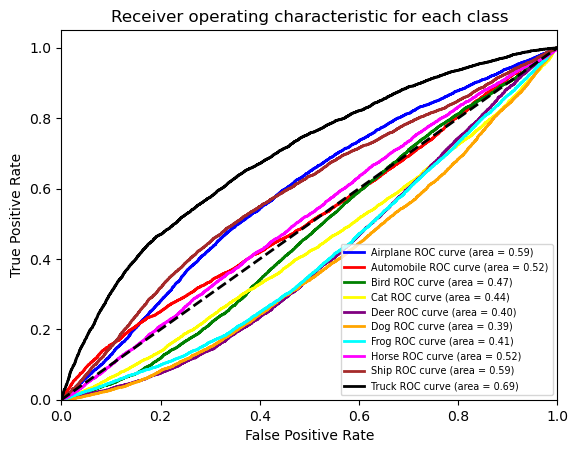

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import VAE  
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Define class descriptions for CIFAR-10
class_descriptions_cifar10 = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

# Assuming the VAE model and data loading are already defined

# Define the Metrics class
class Metrics:
    def __init__(self, model, data_loader, device):
        self.model = model.to(device)
        self.data_loader = data_loader
        self.device = device

    def evaluate(self):
        self.model.eval()
        labels, scores = [], []
        with torch.no_grad():
            for data, target in self.data_loader:
                data = data.to(self.device)
                outputs, mu, log_var = self.model(data)  # Adjust here to unpack mu and log_var
                outputs = outputs.view(outputs.shape[0], -1)
                scores.append(outputs.cpu().numpy())
                labels.append(target.cpu().numpy())
        labels = np.concatenate(labels)
        scores = np.concatenate(scores, axis=0)
        return labels, scores

    def plot_roc_curves(self):
        labels, scores = self.evaluate()
        classes = np.unique(labels)
        y_bin = label_binarize(labels, classes=classes)

        # Compute ROC curve and ROC area for each class
        metrics_dict = {}
        for i, class_ in enumerate(classes):
            current_scores = scores[:, i]
            fpr, tpr, thresholds = roc_curve(y_bin[:, i], current_scores)
            roc_auc = auc(fpr, tpr)
            precision, recall, pr_thresholds = precision_recall_curve(y_bin[:, i], current_scores)
            pr_auc = average_precision_score(y_bin[:, i], current_scores)
            idx = np.min(np.where(tpr >= 0.95)) if np.any(tpr >= 0.95) else -1
            fpr_at_tpr95 = fpr[idx] if idx != -1 else None
            metrics_dict[class_] = {
                "AUROC": roc_auc,
                "AUPR": pr_auc,
                "FPR_at_TPR95": fpr_at_tpr95,
                "Threshold_at_FPR95": thresholds[idx] if idx != -1 else None
            }

        # Print each class's metrics with descriptions
        for key, value in metrics_dict.items():
            class_description = class_descriptions_cifar10[key]
            print(f"{class_description}: AUROC: {value['AUROC']:.2f}, AUPR: {value['AUPR']:.2f}, "
                  f"FPR at TPR 95%: {value['FPR_at_TPR95']}, with Threshold: {value['Threshold_at_FPR95']}")

        # Plot all ROC curves
        plt.figure()
        colors = iter(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'black'])
        for i, class_ in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
            class_description = class_descriptions_cifar10[class_]
            plt.plot(fpr, tpr, color=next(colors), lw=2, label=f'{class_description} ROC curve (area = {metrics_dict[class_]["AUROC"]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for each class')
        plt.legend(loc="lower right", fontsize='x-small')  # Adjust legend fontsize here
        plt.show()

# Assuming you have defined your VAE model and data loader
# Initialize the Metrics class with the trained model and data loader
metrics = Metrics(model_cifar10, cifar10_loader, device)
# Plot ROC curves
metrics.plot_roc_curves()
